In [1]:
#! conda install -y matplotlib
#! conda env export > numpy-pandas-matplotlib.yaml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Separate ML model training data

The respiration rates are bimodally distributed; ML models trained on the whole data set tend to predict the mean value of the data but this doesn't help predict whether sites are hot or cold spots (i.e. either side of the distribution).

One approach to this issue is the `QuantileRegressor`; it seeks to minimize the difference wrt the median (the 50% quantile) instead of the `LinearRegressor` that is minimizing the difference wrt the mean. For a bimodal distribution, then, you could train `QuantileRegressor`s on the 25% and 75% quantiles, thus hitting the two peaks of the bimodal distribution.

However, this requires creating two different ML models and then selecting which is best. We could add different `QuantileRegressors` to the stacked ensemble of SuperLearner submodels. However, at the end of the day, those models' results are all blended/averaged together; how would those weighted averaged results be really any different from the results from a single `LinearRegressor`?

Another approach is motivated by the fact that the `combined.metric` used to guide which sites to sample at is composed of two things: how different that site is compared to other sides (PCA analysis) and the estimated error in the prediction at that site (which is strongly correlated to the magnitude of the respiration rate prediction at that site). This means that higher priority sites tend to be sites where the ML model predicts high respiration rates. Since the model does a reasonable job predicting the order of magnitude of respiration rates, the set of higher priority sites contains all the respiration rate hot spots with some hot spots while the lower priority sites contain only cold spots. ML models trained on the HP sites tend to predict the mean value in the middle of the bimodal distribution. BUT - ML models trained on LP sites, although their scores may be less (see below), they are able to predict a bimodal distribution of respiraiton rates! This leads to the hypothesis that if you train an ML model on cold spots only but ask it to predict the respiration rates at hot spots -> can it detect that there are two dramatically different types of data points? Even though these hot spot predictions are extrapolative, they appear to be the right order of magnitude.

Here, we want to test this hypothesis explicitly by removing all the hot spots from the training set (`N_h`) and then pulling an equal number of random cold spots out (`N_c = N_h`). This combined, equally weighted cold/hot spot dataset will be the fully independent testing set. The remaining points are used for training the ML model.

In [3]:
src_file="ICON-ModEx_Data_Nov-2023.csv"

# Load data
src=pd.read_csv(src_file)

src

,Sample_Kit_ID,Sample_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_Temp_Deg_C,Temp_sd,...,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
0,CM_001,CM_001-1,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
1,CM_001,CM_001-2,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
2,CM_001,CM_001-3,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
3,CM_002,CM_002-1,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
4,CM_002,CM_002-2,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,S19S_0004,S19S_0004-M,9/8/2019,NaN,NaN,PST,NaN,NaN,18.00,NaN,...,Full sunlight (0-20% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755,S19S_0004,S19S_0004-U,9/8/2019,NaN,NaN,PST,NaN,NaN,18.00,NaN,...,Full sunlight (0-20% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756,S19S_0001,S19S_0001-D,9/19/2019,NaN,NaN,PST,NaN,NaN,15.00,NaN,...,Full sunlight (0-20% canopy cover),No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,S19S_0001,S19S_0001-M,9/19/2019,NaN,NaN,PST,NaN,NaN,15.00,NaN,...,Full sunlight (0-20% canopy cover),No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Apply the essential tests for missing data from
# https://github.com/parallelworks/dynamic-learning-rivers/blob/main/scripts/prep_01_intake_train.py
# The commented out blocks will drop rows if missing oxygen, temperature, or pH.
# The ML workflow can use both training and test data with these missing values -
# the missing values are simply filled with the mean. For our purposes, if we
# drop data, we loose the following:
#  69 points for missing respiration rates
# 150 missing oxygen
#   3 missing temperature
#   0 missing pH
# If you apply all three, there are only 585 data points total, pulling
# out the hot spots results in training with ~400. Instead, let's keep
# the NaN and let them get filled in "on-the-fly" only dropping the
# sites with missing respiration rates. We have 690 data points, splitting
# out the hot/cold spots means training on 502 rows.

# Drop any data points with no oxygen (both missing)
# Although looks like we only provide mean and not saturated DO
# at run time -> so comment out the second entry in the list.
#src.dropna(
#    axis='index',
#    inplace=True,
#    how='all',
#    subset=['Mean_DO_mg_per_L']) #,'Mean_DO_percent_saturation'])

# Drop any data points with no temperature
#src.dropna(
#    axis='index',
#    inplace=True,
#    subset=['Mean_Temp_Deg_C'])

# Drop any data points with no pH
#src.dropna(
#    axis='index',
#    inplace=True,
#    subset=['pH'])

# Drop any data points with no respiration rate
src.dropna(
    axis='index',
    inplace=True,
    subset=['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])

src

,Sample_Kit_ID,Sample_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_Temp_Deg_C,Temp_sd,...,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
0,CM_001,CM_001-1,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
1,CM_001,CM_001-2,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
2,CM_001,CM_001-3,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
3,CM_002,CM_002-1,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
4,CM_002,CM_002-2,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,S19S_0032,S19S_0032-M,8/26/2019,NaN,NaN,PDT,9.35,NaN,13.10,NaN,...,Partial direct sunlight (50-80% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
725,S19S_0032,S19S_0032-U,8/26/2019,NaN,NaN,PDT,9.35,NaN,13.10,NaN,...,Accessible direct sunlight (20-50% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
726,S19S_0089,S19S_0089-D,8/26/2019,NaN,NaN,EDT,9.95,NaN,20.80,NaN,...,Full sunlight (0-20% canopy cover),No,Low,NaN,NaN,NaN,NaN,NaN,False,NaN
727,S19S_0089,S19S_0089-M,8/26/2019,NaN,NaN,EDT,9.95,NaN,20.80,NaN,...,Full sunlight (0-20% canopy cover),No,Low,NaN,NaN,NaN,NaN,NaN,False,NaN


In [5]:
# Get the hot spots
hot_spots = src[src['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'] < -500.0]

# Check that there are 94 hot spots
print(np.shape(hot_spots))

# Get 94 randomly selected cold spots
cold_spots = src[src['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'] > -500.0].sample(n=94)

# Join the hot and cold spots into a single testing set
spots = pd.concat([hot_spots, cold_spots], axis='index')

# Get all the Sample_ID for the hot and cold spots
# Use sample ID to drop all the spots from src
src.drop(spots['Sample_ID'].index, inplace=True)

# Write out src as training, spots as testing
spots.to_csv('cold-hot-spot-Nov-2023-testing.csv', mode='w')
src.to_csv('cold-hot-spot-Nov-2023-training.csv', mode='w')

(94, 57)


In [6]:
spots

,Sample_Kit_ID,Sample_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_Temp_Deg_C,Temp_sd,...,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
15,CM_006,CM_006-1,2022-05-15,1.652647e+09,12:37:30,Pacific Standard Time (UTC-8),7.75,0.14,17.80,1.71,...,No coverage,Partial coverage,Partial coverage,More than 10 cm in some places,NaN,"No deviations from the protocol - however, i f...",NaN,No,False,NaN
16,CM_006,CM_006-2,2022-05-15,1.652647e+09,12:37:30,Pacific Standard Time (UTC-8),7.75,0.14,17.80,1.71,...,No coverage,Partial coverage,Partial coverage,More than 10 cm in some places,NaN,"No deviations from the protocol - however, i f...",NaN,No,False,NaN
17,CM_006,CM_006-3,2022-05-15,1.652647e+09,12:37:30,Pacific Standard Time (UTC-8),7.75,0.14,17.80,1.71,...,No coverage,Partial coverage,Partial coverage,More than 10 cm in some places,NaN,"No deviations from the protocol - however, i f...",NaN,No,False,NaN
21,CM_008,CM_008-1,2022-06-17,1.655490e+09,11:20:00,Pacific Daylight Time (UTC-7),19.48,0.27,29.98,0.39,...,No coverage,No coverage,Full coverage,1-3 cm as described in the protocol,river stage/flow is visibly higher than initia...,Sediment substrate surface very rich in dark g...,https://waterdata.usgs.gov/nwis/uv?site_no=110...,NaN,False,NaN
22,CM_008,CM_008-2,2022-06-17,1.655490e+09,11:20:00,Pacific Daylight Time (UTC-7),19.48,0.27,29.98,0.39,...,No coverage,No coverage,Full coverage,1-3 cm as described in the protocol,river stage/flow is visibly higher than initia...,Sediment substrate surface very rich in dark g...,https://waterdata.usgs.gov/nwis/uv?site_no=110...,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,S19S_0082,S19S_0082-U,8/19/2019,NaN,NaN,EDT,NaN,NaN,31.40,NaN,...,Full sunlight (0-20% canopy cover),High,No,NaN,NaN,60ml syringe broke at outlet,NaN,NaN,False,NaN
126,CM_051,CM_051-1,2023-01-24,1.674597e+09,13:42:30,Pacific Standard Time (UTC-8),12.44,0.02,5.05,0.04,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,NaN,NaN,https://data.neonscience.org/data-products/exp...,NaN,False,NaN
248,CM_092,CM_092-3,2023-05-22,1.684790e+09,17:16:30,Eastern Daylight Time (UTC-4),5.61,0.02,26.52,0.05,...,No coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor was deployed about 165 cm below wat...,"The sampling site is a boat ramp, but water th...",NaN,No,False,NaN
493,S19S_0018,S19S_0018-M,8/5/2019,NaN,NaN,EDT,9.80,NaN,18.30,NaN,...,Partial direct sunlight (50-80% canopy cover),No,No,NaN,NaN,NaN,NaN,NaN,False,NaN


In [7]:
src

,Sample_Kit_ID,Sample_ID,Date,Median_Time_Unix,Median_Time_Local,Local_Timezone,Mean_DO_mg_per_L,DO_sd,Mean_Temp_Deg_C,Temp_sd,...,Canopy_Cover,Macrophyte_Coverage,Algal_Mat_Coverage,Sediment_Collection_Depth_cm,MiniDot_Notes,Additional_Sampling_Notes,Hydrograph_Online,Hydrograph_Other,Water_volume_Flag,Notes
0,CM_001,CM_001-1,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
1,CM_001,CM_001-2,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
2,CM_001,CM_001-3,2022-04-27,1.651080e+09,10:22:30,Pacific Daylight Time (UTC-7),10.42,0.06,8.66,0.02,...,Partial coverage,No coverage,No coverage,1-3 cm as described in the protocol,The sensor deployment occured on 4/27/2022,Sediment samples were from across a shoreline ...,https://waterdata.usgs.gov/nwis/uv?site_no=133...,NaN,False,NaN
3,CM_002,CM_002-1,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
4,CM_002,CM_002-2,2022-05-30,1.653926e+09,11:51:30,Eastern Daylight Time (UTC-4),9.58,0.09,19.95,0.24,...,Partial coverage,No coverage,Partial coverage,1-3 cm as described in the protocol,NaN,"We used a meter stick (1 m long, yellow) inste...",https://waterdata.usgs.gov/nwis/inventory?agen...,No,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,S19S_0017,S19S_0017-U,8/26/2019,NaN,NaN,CDT,7.30,NaN,20.70,NaN,...,No or almost no direct sunlight (>80% canopy c...,No,Low,NaN,NaN,NaN,NaN,NaN,False,NaN
723,S19S_0032,S19S_0032-D,8/26/2019,NaN,NaN,PDT,9.35,NaN,13.10,NaN,...,Accessible direct sunlight (20-50% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
724,S19S_0032,S19S_0032-M,8/26/2019,NaN,NaN,PDT,9.35,NaN,13.10,NaN,...,Partial direct sunlight (50-80% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN
725,S19S_0032,S19S_0032-U,8/26/2019,NaN,NaN,PDT,9.35,NaN,13.10,NaN,...,Accessible direct sunlight (20-50% canopy cover),Low,No,NaN,NaN,NaN,NaN,NaN,False,NaN


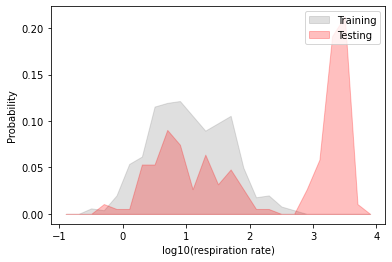

In [8]:
# Plot the distributions

fig, ax = plt.subplots()

# Set binning
nbin=25
min_bin=-1
max_bin=4

#=========================================
# Histogram of the training set
#=========================================
counts, bins = np.histogram(np.log10(np.abs(
    src[
        'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
# Find the center of each bin
# Divide number of counts in each bin by total number of counts => probability
fill_handle = ax.fill_between(
    (bins[:-1]+bins[1:])/2,0,counts/np.sum(counts), 
    color=('gray'), alpha=0.25)

#=========================================
# Histogram of the test set
#=========================================
counts, bins = np.histogram(np.log10(np.abs(
    spots[
        'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])), bins=nbin, range=(min_bin,max_bin))
    
# Find the center of each bin
# Divide number of counts in each bin by total number of counts => probability
fill_handle = ax.fill_between(
    (bins[:-1]+bins[1:])/2,0,counts/np.sum(counts), 
    color=('red'), alpha=0.25)

ax.set_xlabel('log10(respiration rate)')
ax.set_ylabel('Probability')
ax.legend(['Training','Testing'])

In [9]:
# Write out a spots file without the target - necessary for workflow!
spots.pop('Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')
spots.to_csv('cold-hot-spot-Nov-2023-testing-no-target.csv', mode='w')